In [1]:
import cv2
import numpy as np
from math import *
import os
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def GB_total(grid_RGB,cX,cY,interval):
    GB = 0
    t = 0
    for row in grid_RGB[cY:cY+1]:
        for column in row[cX-interval:cX+interval]:
            GB += int(column[1])+int(column[2])
    return GB

In [3]:
def delList(L):
    for i in L:
        if L.count(i) != 1:
            for x in range((L.count(i) - 1)):
                L.remove(i)
    return L

In [4]:
'''triangulation function.
Takes: a list of coordinates of laser spots; sensor horizontal and vertical resolution;
    sensor physical width and height;
    angle alpha, distance D (both set by user);
    focal length f; radius R (set by user);
    current rorated angle (deg); current height (mm)
Returns: a list of the calculated distance and x,y,z coordinates'''
def triangulation(pList,horizontalP,verticalP,sensorWidth,sensorHeight,alpha,D,f,R,angle,height):
    
    distList = []
    xList = []
    yList = []
    zList = []
    #get the central pixel's x and y
    centerx = horizontalP/2
    centery = verticalP/2
    
    for i in pList:
        
        temp = []
        #calculate the horizontal distance of the laser spot to centre of sensor 
        deltaD = abs(centerx-i[0])/horizontalP*sensorWidth
        #calculate the vertical distance of the laser spot to centre of sensor
        h = (i[1]-centery)/verticalP*sensorHeight
        #print("deltaD",deltaD)
        theta = atan(deltaD/f)
        #print("theta",theta)
        H = D/sin(alpha)
        #print("H",H)
        #print("h",h)
        #A is the vertical distance of the laser spot on the object to the current z(height)
        A = h*H/f*(sin(alpha)/sin(alpha+theta))
        z = height + A
        #two cases, depending on if the laser spot is within R or outside of R
        if i[0] < centerx:
            beta = radians(180)-alpha-theta
            deltaR = H*sin(theta)/sin(beta)
            polorCoordinate = R + deltaR
        else:
            beta = alpha-theta
            deltaR = H*sin(theta)/sin(beta)
            polorCoordinate = R - deltaR
            
        #get the Cartesian coordinates from the angle and the distance    
        xList.append(polorCoordinate*cos(angle))
        yList.append(polorCoordinate*sin(angle))
        zList.append(z)
        distList.append(polorCoordinate)

    return distList,xList,yList,zList

------Begin to capture skl.png------

center point 1 : 121 182
GB total: 1692

center point 2 : 130 172
GB total: 1896

center point 3 : 123 117
GB total: 1468

x: 69.44661854762272 y: 0.0 z: -0.21524690169695582 distance: 69.44661854762272 x: 115 y 85
x: 68.87406397008286 y: 0.0 z: 0.3426135377988153 distance: 68.87406397008286 x: 116 y 87
x: 68.87406397008286 y: 0.0 z: 0.6352616124109733 distance: 68.87406397008286 x: 116 y 88
x: 67.13670904147723 y: 0.0 z: 0.8539828923272594 distance: 67.13670904147723 x: 119 y 89
x: 67.13670904147723 y: 0.0 z: 1.1490157022521874 distance: 67.13670904147723 x: 119 y 90
x: 66.55093267180676 y: 0.0 z: 1.4206714317329894 distance: 66.55093267180676 x: 120 y 91
x: 66.55093267180676 y: 0.0 z: 1.7165103478801296 distance: 66.55093267180676 x: 120 y 92
x: 65.96177929229394 y: 0.0 z: 1.9904310728952854 distance: 65.96177929229394 x: 121 y 93
x: 65.96177929229394 y: 0.0 z: 2.287081773899165 distance: 65.96177929229394 x: 121 y 94
x: 65.36921961574714 y: 0.0 

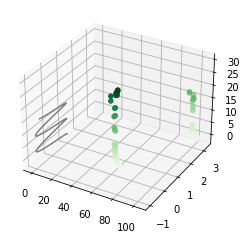

In [6]:
if __name__ == "__main__":
    
#   cwd = os.getcwd() + "/Images/"
    cwd = "Test_2/" #change this to the image folder if needed 
    files = sorted(os.listdir(cwd))
    angle = 0
    height = 10
    x_total_list = []
    y_total_list = []
    z_total_list = []
    
    #--------------------------Spot Detection Part----------------------#
    #looping through iamges
    for file in files:
        print("------" + "Begin to capture " + file + "------" + '\n')
        img = cv2.imread(cwd + file)
        #colourspace conversion
        grid_RGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        grid_HSV = cv2.cvtColor(grid_RGB, cv2.COLOR_RGB2HSV)
        #HSV: colour (0-179); saturation (0-255); brightness (0-255)
        
        #set the threshold values and masking
        lower1 = np.array([0,0,247])
        upper1 = np.array([180,150,255])
        mask1 = cv2.inRange(grid_HSV, lower1, upper1)
        res1 = cv2.bitwise_and(grid_RGB, grid_RGB, mask=mask1)

        lower2 = np.array([0,150,247])
        upper2 = np.array([10,255,255])
        mask2 = cv2.inRange(grid_HSV, lower2, upper2)
        res2 = cv2.bitwise_and(grid_RGB, grid_RGB, mask=mask2)
        
        #combining the two masks together, adn find the red area
        mask3 = mask1 + mask2
        mask3 = cv2.GaussianBlur(mask3,(5, 5), 0)
        ret, binaryMask = cv2.threshold(mask3, 100, 255, cv2.THRESH_BINARY);
        contours, hierarchy = cv2.findContours(binaryMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE);
        #cv2.imshow("img1", img)
        
        # maxX = 0
        # maxY = 0
        t = 1
        num = 0
        interval = 3
        max = 200  #filter for max GB total
        spotList = []
        for i in range(len(contours)):
            M = cv2.moments(contours[i])
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
            else:
                cX,cY = 0,0
            print("center point",t,":",cX,cY)
            t += 1
            print("GB total:",GB_total(grid_RGB,cX,cY,interval))
            if GB_total(grid_RGB,cX,cY,interval)/(interval*2*2) < 175:
                for j in contours[i]:
                    temp = []
                    temp.append(j[0][0])
                    temp.append(j[0][1])
                    spotList.append(temp)
                spotList.sort(key=(lambda x:x[1]))
                lasty = spotList[-1][1]
                for k in range(len(spotList) - 2, -1, -1):
                    if lasty == spotList[k][1]:
                        del spotList[k]
                    else:
                        lasty = spotList[k][1]
                cv2.drawContours(img, [contours[i]], -1, (0,255,0), thickness = -1)
            print()
        #print("Max:",maxX,maxY)


        cv2.imshow("mask3", mask3)

        #cv2.imshow("img2", img)
        
        
        if(len(spotList) == 0):
            print("No red laser captured!\n")
            
        
        #-----------------------Triangulation Part--------------------#
        #triangulation(pList,horizontalP,sensorWidth,alpha,D,f)
        horizontalP = img.shape[1]
        verticalP = img.shape[0]
        sensorWidth = 3
        sensorHeight = 2
        alpha = radians(30)
        D = 100
        f = 5
        R = 40
        dist_list,xList,yList,zList = triangulation(spotList,horizontalP,verticalP,sensorWidth,sensorHeight,alpha,D,f,R,angle,height)
        x_total_list += xList
        y_total_list += yList
        z_total_list += zList
        
        for i in range (len(dist_list)):
            print("x:",xList[i],"y:",yList[i],"z:",zList[i],"distance:",dist_list[i],"x:",spotList[i][0],"y",spotList[i][1])
        #print(len(deltaR_list))
        green = [0,255,0]
        for i in range (len(dist_list)): 
            img[spotList[i][1],spotList[i][0]] = green
        cv2.imshow("img3",img)
        
        
        angle += radians(1.8) #default step size 1.8 for NEMA 17
        #if one rotation finished
        if(angle == radians(360)):
            angle = 0
            height += 10
        print("------" + "End of capturing "+file + "------" + '\n\n')
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    ax = plt.axes(projection='3d')

    # Data for a three-dimensional line
    zline = np.linspace(0, 15, 1000)
    xline = np.sin(zline)
    yline = np.cos(zline)
    ax.plot3D(xline, yline, zline, 'gray')

    # Data for three-dimensional scattered points
    ax.scatter3D(x_total_list, y_total_list, z_total_list, c=z_total_list, cmap='Greens');






In [18]:
num1 = [1,2,3]
num2 = [4,5,6]

print(num1+num2)

[1, 2, 3, 4, 5, 6]
